# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with 

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise
arms - This is the number of categories we will have
turns - How many times we go around the spiral
width - How wide is the spiral (percentage of the radius)
noise - How much noise we will add to the data.
size - The number of points to generate

In [58]:
arms = 3
turns = 1.5
width = 0.3
noise = .25
size = 4000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


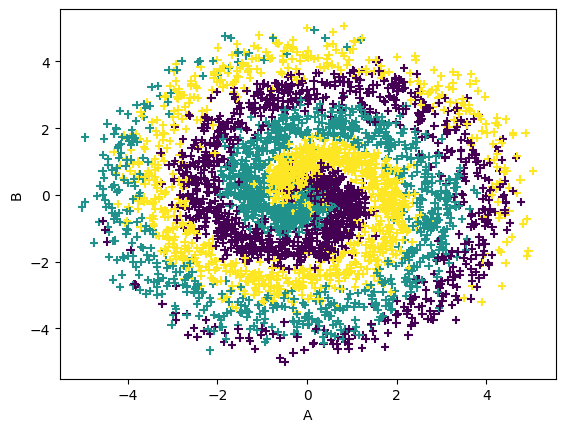

In [59]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [61]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[191  35  40]
 [ 30 199  38]
 [ 25  25 217]]
Accuracy is   0.75875
Precision is  0.7600982040772243
Recall is     0.75875
F1 is         0.7583452069615323


### Train and evaluate SVC model 

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[817 127 123]
 [145 797 124]
 [154 145 767]]
Accuracy is   0.7442950922163176
Precision is  0.7446779617846842
Recall is     0.7442950922163176
F1 is         0.7442064922510695

Results for svc on test data
  Default settings
Confusion Matrix
[[194  34  38]
 [ 44 190  33]
 [ 35  41 191]]
Accuracy is   0.71875
Precision is  0.7188808018221635
Recall is     0.71875
F1 is         0.7187501227505954


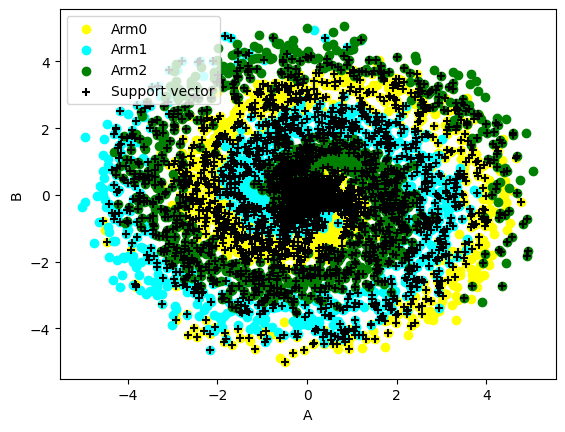

In [64]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [65]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[911  86  70]
 [ 75 906  85]
 [ 76  84 906]]
Accuracy is   0.8512035010940919
Precision is  0.8512468145936358
Recall is     0.8512035010940919
F1 is         0.8512158707291615

Results for NN on test data
  Default settings
Confusion Matrix
[[220  24  22]
 [ 21 222  24]
 [ 18  24 225]]
Accuracy is   0.83375
Precision is  0.8339478075861839
Recall is     0.83375
F1 is         0.8337753092701432


C:\Users\habto\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91
|ADA|A,B(150 estimators)|84.9|84.9|83.2|83.2| 
|RF|A,B (150 estimators) |100|100|79.3|79.4|
|VM| A,B layers(50,25,10) |89.6|89.6|82.1|82.2|
|CV|   Splits(10) |76.94|Avg|75.7|


### Train and evaluate ADA boosted model 

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  
X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
ada_model.fit(X,y)

y_pred = ada_model.predict(X)

print('Results for ADA on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for ADA on train data
  Default settings
Confusion Matrix
[[906  90  71]
 [ 70 909  87]
 [ 81  84 901]]
Accuracy is   0.849015317286652
Precision is  0.8490960765922205
Recall is     0.849015317286652
F1 is         0.8490286809349419

Results for ADA on test data
  Default settings
Confusion Matrix
[[219  24  23]
 [ 22 224  21]
 [ 18  26 223]]
Accuracy is   0.8325
Precision is  0.8327453639771158
Recall is     0.8325
F1 is         0.83252707948244


C:\Users\habto\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Train and evaluate Random Forest model

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier()
rf_model.fit(X,y)

y_pred = rf_model.predict(X)

print('Results for Random Forest on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf_model.predict(X_test)

print('Results for Random Fores on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))

Results for Random Forest on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Fores on test data
  Default settings
Confusion Matrix
[[207  29  30]
 [ 26 213  28]
 [ 23  29 215]]
Accuracy is   0.79375
Precision is  0.7940209391695136
Recall is     0.79375
F1 is         0.7937412315372673


### Train and evaluate Voting model 

In [69]:
from sklearn.ensemble import VotingClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier 
# Build the classifiers 
vc1_dt = DecisionTreeClassifier() 
vc2_svm = SVC() 
vc3_nn  =  MLPClassifier(hidden_layer_sizes=(50, 25, 10), 
                         solver='lbfgs') 

# Bundle into a list with names 
vcList = [('DT',vc1_dt), 
('SVM',vc2_svm), 
('NN',vc3_nn)] 
X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

vote_model = VotingClassifier(vcList) 
vote_model.fit(X,y) 
y_pred = vote_model.predict(X)  
print('Results for Voting Ensemble on training data') 
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = vote_model.predict(X_test) 
print('Results for Voting Ensemble on test data') 
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


C:\Users\habto\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on training data
  Default settings
Confusion Matrix
[[978  61  28]
 [ 52 946  68]
 [ 82  42 942]]
Accuracy is   0.8959049703032198
Precision is  0.8962687895356435
Recall is     0.8959049703032198
F1 is         0.8958870165521627

Results for Voting Ensemble on test data
  Default settings
Confusion Matrix
[[218  25  23]
 [ 28 211  28]
 [ 23  16 228]]
Accuracy is   0.82125
Precision is  0.8216523067885266
Recall is     0.82125
F1 is         0.8210810587230284


### Cross Validate a Decision Tree model  

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix
accuracy_list = np.array([]) 
f1_list = np.array([]) 

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_indices, validate_indices in splitter.split(spiral, 
spiral['Class']): 
 train_set = spiral.iloc[train_indices] 
 validate_set = spiral.iloc[validate_indices] 
 X = train_set[['A','B' ]] 
 y = train_set['Class'] 
 X_validate = validate_set[['A','B']] 
 y_validate = validate_set['Class'] 
 model = DecisionTreeClassifier() 
 model.fit(X,y) 
 y_validate_pred = model.predict(X_validate) 
 accuracy = accuracy_score(y_validate, y_validate_pred) 
 print("Confusion Matrix") 
 print(confusion_matrix(y_validate, y_validate_pred)) 
 print('Accuracy is ', accuracy) 
 accuracy_list = np.insert(accuracy_list, 0, accuracy)
print("Accuracy values", accuracy_list) 
print("   Average of ", np.average(accuracy_list)) 
print("   StDev of ", np.std(accuracy_list)) 


Confusion Matrix
[[108  10  16]
 [ 11 109  13]
 [ 18  21  94]]
Accuracy is  0.7775
Confusion Matrix
[[105  17  12]
 [ 15 103  15]
 [ 12  14 107]]
Accuracy is  0.7875
Confusion Matrix
[[103  16  15]
 [ 14  98  21]
 [ 14  24  95]]
Accuracy is  0.74
Confusion Matrix
[[104  15  14]
 [ 21  96  17]
 [ 20  13 100]]
Accuracy is  0.75
Confusion Matrix
[[ 91  22  20]
 [ 25  94  15]
 [ 15  12 106]]
Accuracy is  0.7275
Confusion Matrix
[[ 98  25  10]
 [ 10 110  14]
 [ 14  18 101]]
Accuracy is  0.7725
Confusion Matrix
[[100  15  18]
 [ 25  97  11]
 [ 15  17 102]]
Accuracy is  0.7475
Confusion Matrix
[[104  18  11]
 [ 17  96  20]
 [ 18  13 103]]
Accuracy is  0.7575
Confusion Matrix
[[99 17 17]
 [20 97 16]
 [18 17 99]]
Accuracy is  0.7375
Confusion Matrix
[[ 99  18  16]
 [ 18  99  16]
 [ 15   9 109]]
Accuracy is  0.7694235588972431
Accuracy values [0.76942356 0.7375     0.7575     0.7475     0.7725     0.7275
 0.75       0.74       0.7875     0.7775    ]
   Average of  0.7566923558897243
   StDev of 

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


X = train_set[['A', 'B']]
y = train_set['Class']
X_test = test_set[['A', 'B']]
y_test = test_set['Class']


rf_model_default = RandomForestClassifier()
rf_model_default.fit(X, y)


y_pred_train_default = rf_model_default.predict(X)


y_pred_test_default = rf_model_default.predict(X_test)

print('Results for Random Forest on training data (default settings)')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred_train_default))
print('Accuracy is  ', accuracy_score(y, y_pred_train_default))
print('Precision is ', precision_score(y, y_pred_train_default, average='weighted'))
print('Recall is    ', recall_score(y, y_pred_train_default, average='weighted'))
print('F1 is        ', f1_score(y, y_pred_train_default, average='weighted'))
print()

print('Results for Random Forest on test data (default settings)')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test_default))
print('Accuracy is  ', accuracy_score(y_test, y_pred_test_default))
print('Precision is ', precision_score(y_test, y_pred_test_default, average='weighted'))
print('Recall is    ', recall_score(y_test, y_pred_test_default, average='weighted'))
print('F1 is        ', f1_score(y_test, y_pred_test_default, average='weighted'))
print()

# Train Random Forest with increased n_estimators
rf_model_increased = RandomForestClassifier(n_estimators=200)
rf_model_increased.fit(X, y)

# Predict on training data with increased n_estimators
y_pred_train_increased = rf_model_increased.predict(X)

# Predict on test data with increased n_estimators
y_pred_test_increased = rf_model_increased.predict(X_test)

print('Results for Random Forest on training data (n_estimators=200)')
print('  Increased n_estimators')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred_train_increased))
print('Accuracy is  ', accuracy_score(y, y_pred_train_increased))
print('Precision is ', precision_score(y, y_pred_train_increased, average='weighted'))
print('Recall is    ', recall_score(y, y_pred_train_increased, average='weighted'))
print('F1 is        ', f1_score(y, y_pred_train_increased, average='weighted'))
print()

print('Results for Random Forest on test data (n_estimators=200)')
print('  Increased n_estimators')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test_increased))
print('Accuracy is  ', accuracy_score(y_test, y_pred_test_increased))
print('Precision is ', precision_score(y_test, y_pred_test_increased, average='weighted'))
print('Recall is    ', recall_score(y_test, y_pred_test_increased, average='weighted'))
print('F1 is        ', f1_score(y_test, y_pred_test_increased, average='weighted'))


Results for Random Forest on training data (default settings)
  Default settings
Confusion Matrix
[[1200    0    0]
 [   0 1200    0]
 [   0    0 1200]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data (default settings)
  Default settings
Confusion Matrix
[[258   3   5]
 [  5 258   4]
 [  3   1 263]]
Accuracy is   0.97375
Precision is  0.97386138162326
Recall is     0.97375
F1 is         0.9737485752163042

Results for Random Forest on training data (n_estimators=200)
  Increased n_estimators
Confusion Matrix
[[1200    0    0]
 [   0 1200    0]
 [   0    0 1200]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data (n_estimators=200)
  Increased n_estimators
Confusion Matrix
[[256   4   6]
 [  5 258   4]
 [  4   1 262]]
Accuracy is   0.97
Precision is  0.9700922695473554
Recall is     0.97
F1 is         0.9699985654038146


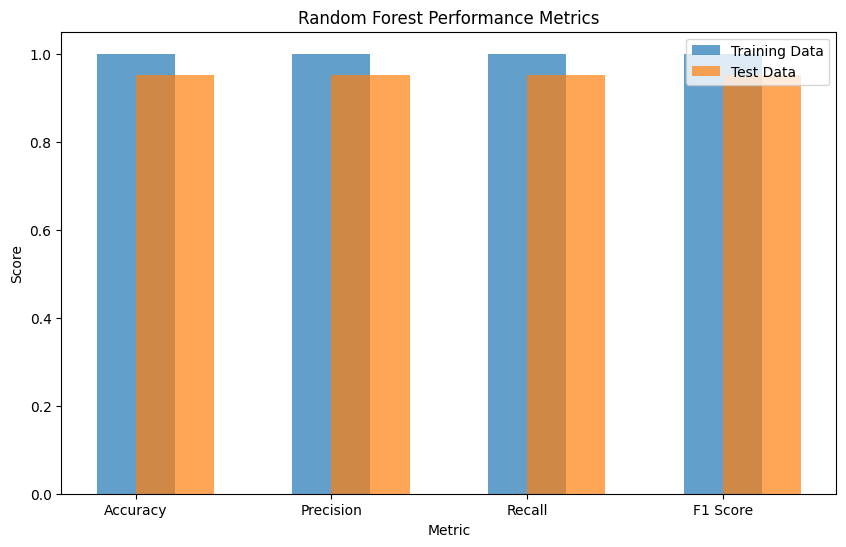

In [82]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assume X_train, y_train, X_test, y_test are already defined

# Increase the number of estimators
rf_model_updated = RandomForestClassifier(n_estimators=200, random_state=123)
rf_model_updated.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = rf_model_updated.predict(X_train)
y_test_pred = rf_model_updated.predict(X_test)

# Calculate metrics for training data
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Calculate metrics for test data
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Plotting
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores = [accuracy_train, precision_train, recall_train, f1_train]
test_scores = [accuracy_test, precision_test, recall_test, f1_test]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Training Data', align='center', alpha=0.7)
plt.bar(x, test_scores, width=0.4, label='Test Data', align='edge', alpha=0.7)

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Random Forest Performance Metrics')
plt.xticks(x, labels)
plt.legend()

plt.show()
